In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import math

In [31]:
raw = pd.read_csv('medical_insurance.csv')

In [32]:
raw.columns

Index(['person_id', 'age', 'sex', 'region', 'urban_rural', 'income',
       'education', 'marital_status', 'employment_status', 'household_size',
       'dependents', 'bmi', 'smoker', 'alcohol_freq', 'visits_last_year',
       'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
       'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c',
       'plan_type', 'network_tier', 'deductible', 'copay', 'policy_term_years',
       'policy_changes_last_2yrs', 'provider_quality', 'risk_score',
       'annual_medical_cost', 'annual_premium', 'monthly_premium',
       'claims_count', 'avg_claim_amount', 'total_claims_paid',
       'chronic_count', 'hypertension', 'diabetes', 'asthma', 'copd',
       'cardiovascular_disease', 'cancer_history', 'kidney_disease',
       'liver_disease', 'arthritis', 'mental_health', 'proc_imaging_count',
       'proc_surgery_count', 'proc_physio_count', 'proc_consult_count',
       'proc_lab_count', 'is_high_risk', 'had_major_procedure'],
      

In [64]:
data = raw.drop(['avg_claim_amount', 'annual_premium', 'monthly_premium', 'income', 'network_tier', 'employment_status', 'marital_status', 'dependents'], axis=1)

# draw these simple boolean columns out from the categorical columns to allow easier analysis and correlation
data['is_current_smoker'] = (data['smoker'] == 'Current')
data['is_former_smoker'] = (data['smoker'] == 'Former')

data['drinks_alcohol'] = (data['alcohol_freq'] != 'None')

data['is_male'] = (data['sex'] == 'Male')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   education                    100000 non-null  object 
 6   household_size               100000 non-null  int64  
 7   bmi                          100000 non-null  float64
 8   smoker                       100000 non-null  object 
 9   alcohol_freq                 100000 non-null  object 
 10  visits_last_year             100000 non-null  int64  
 11  hospitalizations_last_3yrs   100000 non-null  int64  
 12  days_hospitalized_last_3yrs  100000 non-null  int64  
 13  

In [65]:
corr_matrix = data.corr(numeric_only=True)

In [66]:
risk_score_correlations = corr_matrix['risk_score']

In [67]:
# find all columns that correlate with risk score a notable amount (>0.1)
high_risk_score_correlations = risk_score_correlations[abs(risk_score_correlations) > 0.1].sort_values(ascending=False)[2:] # remove first two columns because they are not relevant
high_risk_score_correlations
# Age has highest correlation with risk score
# Then number of chronic conditions,
# Then blood pressure. Apparently systolic is more important than diastolic

age                       0.720989
chronic_count             0.666014
systolic_bp               0.553843
diastolic_bp              0.379526
hypertension              0.346731
is_current_smoker         0.322118
visits_last_year          0.313346
claims_count              0.311008
annual_medical_cost       0.305971
total_claims_paid         0.305782
mental_health             0.285307
arthritis                 0.265102
medication_count          0.264541
diabetes                  0.233629
asthma                    0.193422
hba1c                     0.183235
cardiovascular_disease    0.177263
proc_surgery_count        0.170409
copd                      0.147499
cancer_history            0.118792
had_major_procedure       0.114677
proc_lab_count            0.110210
proc_imaging_count        0.109206
bmi                       0.108921
proc_consult_count        0.104791
proc_physio_count         0.102407
liver_disease             0.101039
Name: risk_score, dtype: float64

In [44]:
# negative risk score correlation means they are likely beneficial to your health
negative_risk_score_correlations = risk_score_correlations[risk_score_correlations < 0].sort_values(ascending=True)
# these are very low so it's questionable if they matter at all. Provider quality could matter a small amount
negative_risk_score_correlations

is_former_smoker    -0.060646
provider_quality    -0.002406
copay               -0.001494
policy_term_years   -0.001312
Name: risk_score, dtype: float64

In [45]:
# is_high_risk just means risk_score > 0.6
high_risk_people = data[data['is_high_risk'] == True]
low_risk_people = data[data['is_high_risk'] == False]

# Age
Age has the highest correlation with risk score

<Axes: title={'center': 'Age distribution of dataset'}, ylabel='Frequency'>

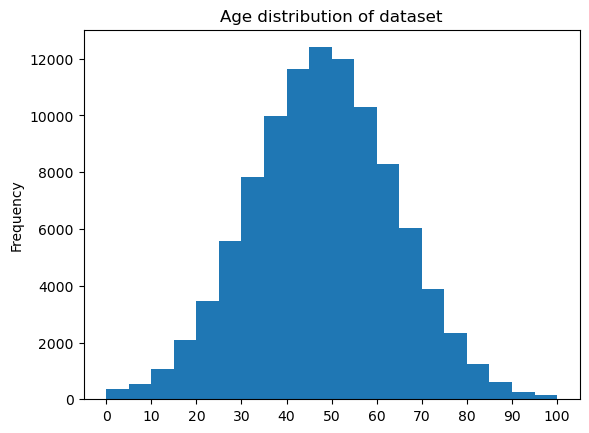

In [51]:
data['age'].plot.hist(bins=20, xticks=range(0, 110, 10), title="Age distribution of dataset")

In [10]:
average_age = data['age'].mean()
average_age

47.5215

In [56]:
# correlations with age
age_correlations = data.corr(numeric_only=True)['age']
irrelevant_age_cols = ['age', 'person_id', 'is_high_risk']
for col in irrelevant_age_cols:
    age_correlations.pop(col)
relevant_age_correlations = age_correlations[age_correlations > 0.1].sort_values(ascending=False)
relevant_age_correlations

risk_score             0.720989
systolic_bp            0.555174
diastolic_bp           0.304183
chronic_count          0.136148
annual_medical_cost    0.131166
ldl                    0.110565
total_claims_paid      0.101717
Name: age, dtype: float64

Of the attributes we are looking at, blood pressure and number of chronic conditions are the main things that go up as you age that affect risk score

# Smoking

As seen in the graph below, current smokers have a much higher risk score on average than those who are not.
Surprisingly, former smokers have an almost identical risk score on average to those who never smoked

<Axes: xlabel='smoker', ylabel='Risk score'>

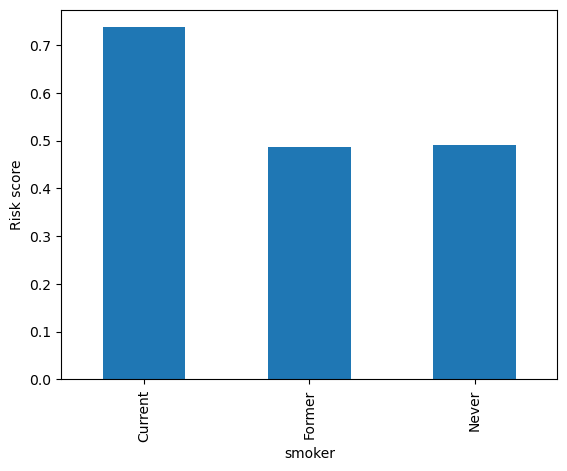

In [69]:
data.groupby('smoker')['risk_score'].mean().plot.bar(ylabel="Risk score")

# Alcohol
Surprisingly, alcohol seems to have no real effect on the risk score

In [57]:
data['alcohol_freq'].value_counts()

Occasional    45078
None          30083
Weekly        19833
Daily          5006
Name: alcohol_freq, dtype: int64

Text(0.5, 1.0, 'Risk score by frequency of alcohol consumption')

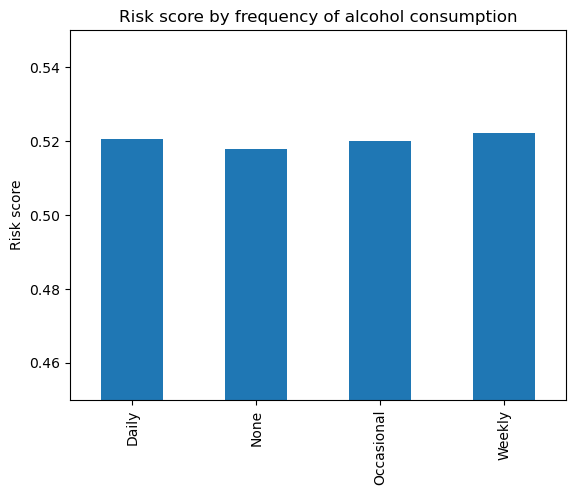

In [72]:
data.groupby('alcohol_freq')['risk_score'].mean().plot.bar()
plt.ylim(0.45 , 0.55)
plt.ylabel("Risk score")
plt.xlabel(None)
plt.title("Risk score by frequency of alcohol consumption")

# Sex

Men and women have basically identical risk scores on average. 'Other' has a very slightly lower risk score for some reason. Probably just random variation because there 

Text(0, 0.5, 'Risk Score')

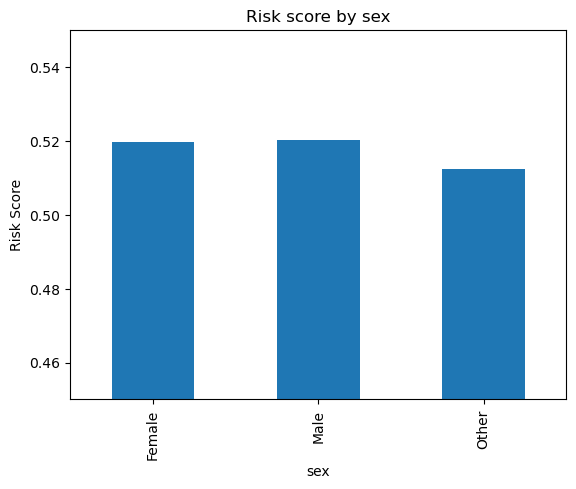

In [75]:
data.groupby('sex')['risk_score'].mean().plot.bar()
plt.ylim(0.45 , 0.55)
plt.title("Risk score by sex")
plt.ylabel("Risk Score")

# Value counts

In [ ]:
for col in data.columns:
    print(data[col].value_counts(), "\n")